This is a practice to implement an AutoEncoder on MNIST dataset.

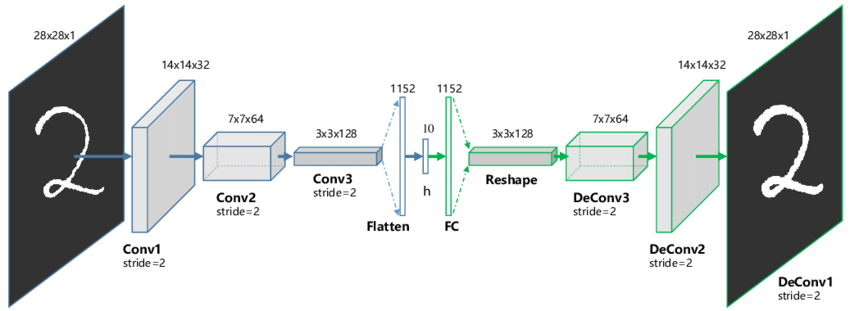

An AE consists of two main parts:

<ol>
<li>Encoder</li>
<li>Decoder</li>
</ol>

**Encoder**: This network will take the input and using its layers, tries to create a lower dimention representation of the input. For instance, the network above takes a 28x28 image and will shrink its dimentinality into
 and array of $R^{10}$.

**Decoder**: In contrast to encoder, decoder will take representation vector the the encoder has created and will ty to recreate intial input. Here, deocer take the array and will try to recreate the input image.

If the process is done correctly and AE is able to recreate its intial input, we can assume that the low dimention vector is representing the whole image. So we are able to use that vector instead on the whole image. This 
will lower computational cost.

AE is an unsupervised algorithm that is useful when we don't have labels for our data and we want to have a lower dimention representation for our intial data.

---
 

**MNIST** dataset

The MNIST dataset is a widely used database of handwritten digits that contains 60,000 training examples and 10,000 test examples. It is commonly used for training image processing systems.

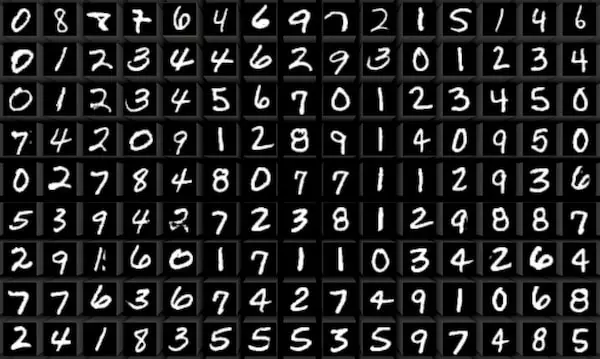

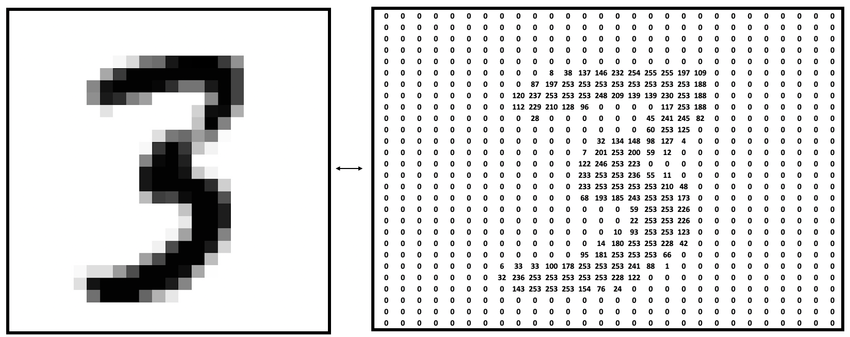


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
import shutil
from IPython.display import clear_output

In [ ]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

## Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

Classes and Functions defined

In [ ]:
# Class to flatten the imaege when it downloads
class FlattenImage:
    def __call__(self,img):
        return img.view(-1)

Creating the data directory and loading the data

In [ ]:
# Path of folders
mnist_dir = '/content/MNIST'
train_dir = os.path.join(mnist_dir,'train')
test_dir = os.path.join(mnist_dir,'test')

# making paths
if not os.path.isdir(mnist_dir):
    os.makedirs(train_dir)
    os.mkdir(test_dir)

# Setting transforms to the data
data_transforms = transforms.Compose(
        [
        transforms.ToTensor(),      # Transform the data to tensor
        transforms.Normalize((0.5,),(0.5,)),     # Normalizing the data
        FlattenImage(),
        ]
    )

# Download data
mnist_train = datasets.MNIST(root=train_dir, train=True, download=True, transform=data_transforms)
mnist_test = datasets.MNIST(root=test_dir, train=False, download=True, transform=data_transforms)

# Load data on the system
batch_size = 32
train_data = torch.utils.data.DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(mnist_test, shuffle=True)

# shape of the data
train_example = iter(train_data)
train_example, train_target = next(train_example)
print(f'The shape of the training data is {train_example.shape}')
print(f'The target of the chosen example is {train_target}', end='\n\n')

test_example = iter(test_data)
test_example, test_target = next(test_example)
print(f'The shape of the test data is {test_example.shape}')
print(f'The target of the test example is {test_target}')


100%|██████████| 9912422/9912422 [00:00<00:00, 133407278.30it/s]

Extracting /content/MNIST/train/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/train/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 110828631.13it/s]


Extracting /content/MNIST/train/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46428154.03it/s]

Extracting /content/MNIST/train/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/train/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18549687.21it/s]


Extracting /content/MNIST/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/train/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 136606279.16it/s]

Extracting /content/MNIST/test/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/test/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 102138021.77it/s]


Extracting /content/MNIST/test/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/test/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38245477.20it/s]


Extracting /content/MNIST/test/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/test/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19659988.41it/s]


Extracting /content/MNIST/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/test/MNIST/raw

The shape of the training data is torch.Size([32, 784])
The target of the chosen example is tensor([0, 8, 5, 0, 5, 7, 3, 6, 7, 2, 3, 6, 4, 9, 6, 1, 6, 9, 1, 9, 9, 3, 9, 9,
        8, 9, 0, 0, 7, 3, 3, 9])

The shape of the test data is torch.Size([1, 784])
The target of the test example is tensor([9])


Auto Encoder model

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encode1 = nn.Linear(784,512)
        self.encode2 = nn.Linear(512,128)
        self.encode3 = nn.Linear(128,32)
        self.encode4 = nn.Linear(32,10)

        self.decoder = nn.Sequential(
            nn.Linear(10,32),
            nn.Tanh(), # ====> nn.Tanh are used in this kind of situation
            nn.Linear(32,128),
            nn.Tanh(),
            nn.Linear(128,512),
            nn.Tanh(),
            nn.Linear(512,784),
            nn.Sigmoid()
            )

    def forward(self,x):
        # x = x.view(-1, 28*28) # You can reshape the data from here or when downloading them
        x = self.encode1(x)
        x = F.tanh(F.relu(self.encode2(x))) # ====> F.tanh are used when there is an input to put it in
        x = F.tanh(F.relu(self.encode3(x)))
        encoded = F.tanh(self.encode4(x))
        decoded = self.decoder(encoded)
        return decoded

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

Creating a custom Cost funtion


In [ ]:
class WeightedLoss(nn.Module):
    def __init__(self, weights):
        super(WeightedLoss, self).__init__()
        self.weights = weights

    def forward(self, predictions,input, targets):
        grad = (predictions - input)**2
        loss = torch.matmul(grad,self.weights.t())
        loss = torch.sum(loss)/len(targets)
        loss = loss / predictions.shape[1]
        return loss

class Weights:
    def __init__(self, image,target):
        self.image = image
        self.target = target
        self.weights = self.calc_weight()

    def calc_weight(self):

        weights_same = []
        weights_not = []
        for p in range(28*28):
            sam_num, not_num = 0, 0
            for i in range(10):
                f_value_same = self.image[self.target==i,p]
                val1_same, val2_same = torch.meshgrid(f_value_same, f_value_same)
                sub_matrix_same = torch.exp(-(val1_same - val2_same)**2)
                sub_vals_same = torch.triu(sub_matrix_same, diagonal=1)
                sam_num += sum(range(len(sub_matrix_same)))

                f_value_not = self.image[self.target!=i,p]
                val1_not, val2_not = torch.meshgrid(f_value_not, f_value_not)
                sub_matrix_not = 1 - torch.exp(-(val1_not - val2_not)**2)
                sub_vals_not = torch.triu(sub_matrix_not, diagonal=1)
                not_num += sum(range(len(sub_matrix_not)))

            weights_same.append(torch.sum(sub_vals_same) / sam_num)
            weights_not.append(torch.sum(sub_vals_not) / not_num)

        self.weights_same = torch.tensor(weights_same)
        self.weights_not = torch.tensor(weights_not)
        return self.weights_same * self.weights_not








Extract all weights

In [ ]:
from tqdm import trange, tqdm

In [ ]:
all_weights = torch.zeros(len(train_data),28*28)
td = iter(train_data)
# Providing range for printing the progress
pbar = trange(int(len(train_data)), desc="Extracting Weights", unit="batch")
for i in pbar:
    (input,target) = next(td)
    weights = Weights(input,target).weights
    all_weights[i,:] = weights
torch.save(all_weights, '/content/drive/MyDrive/Kalhor/e1q3_weights.pt')

Extracting Weights: 100%|██████████| 1875/1875 [48:21<00:00,  1.55s/batch]


Loading saved weights

In [ ]:
training_weights = torch.load('/content/drive/MyDrive/Kalhor/e1q3_weights.pt')
training_weights = training_weights.to(device)

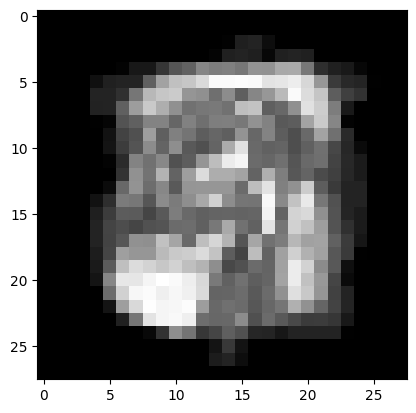

In [ ]:
image = training_weights[1000]
image = image.reshape(28,28)
plt.imshow(image, cmap = 'gray')

compiling the model

In [ ]:
autoencoder = AutoEncoder().to(device)
criterion_l2 = nn.MSELoss()
criterion = WeightedLoss(training_weights)
optimizer = optim.SGD(autoencoder.parameters(), lr=0.01)

Train the model

In [ ]:
epochs = 30
Loss = []
for epoch in range(epochs):

    l = []
    pbar = tqdm(enumerate(train_data), total=len(train_data), desc=f'Epoch {epoch+1}/{epochs}', position=0)
    for i,(input, target) in pbar:

        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        predictions = autoencoder(input)
        loss1 = criterion(predictions, input,target)
        mae = criterion_l2(predictions,input)
        loss =loss1 + mae
        loss.backward()
        optimizer.step()
        pbar.set_description(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, mse: {mae:.4f}, loss_main: {loss1:.4f}')
    Loss.append(loss.cpu().detach().numpy())
    pbar.close()

Epoch 1/30, Loss: 2.7669, mse: 1.0606, loss_main: 1.7063: 100%|██████████| 1875/1875 [00:27<00:00, 68.80it/s]
Epoch 2/30, Loss: 2.6338, mse: 0.9637, loss_main: 1.6701: 100%|██████████| 1875/1875 [00:25<00:00, 72.18it/s]
Epoch 3/30, Loss: 2.6182, mse: 0.9478, loss_main: 1.6705: 100%|██████████| 1875/1875 [00:27<00:00, 68.55it/s]
Epoch 4/30, Loss: 2.6091, mse: 0.9414, loss_main: 1.6676: 100%|██████████| 1875/1875 [00:26<00:00, 69.60it/s]
Epoch 5/30, Loss: 2.6036, mse: 0.9386, loss_main: 1.6650: 100%|██████████| 1875/1875 [00:25<00:00, 73.34it/s]
Epoch 6/30, Loss: 2.5831, mse: 0.9332, loss_main: 1.6498: 100%|██████████| 1875/1875 [00:25<00:00, 73.02it/s]
Epoch 7/30, Loss: 2.6125, mse: 0.9371, loss_main: 1.6754: 100%|██████████| 1875/1875 [00:25<00:00, 73.91it/s]
Epoch 8/30, Loss: 2.5625, mse: 0.9258, loss_main: 1.6368: 100%|██████████| 1875/1875 [00:25<00:00, 72.77it/s]
Epoch 9/30, Loss: 2.5702, mse: 0.9263, loss_main: 1.6439: 100%|██████████| 1875/1875 [00:25<00:00, 72.68it/s]
Epoch 10/3

Text(0.5, 0, 'Epochs')

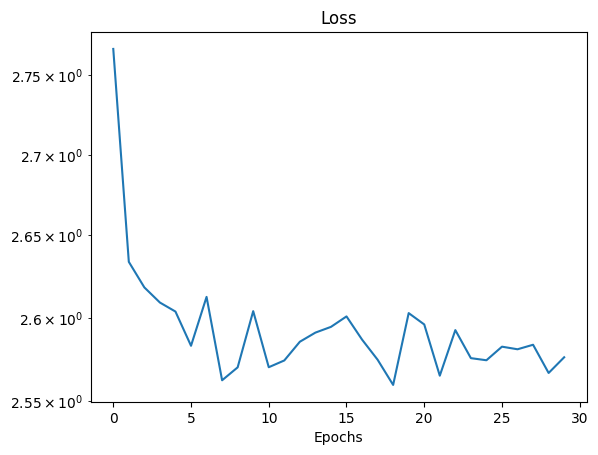

In [ ]:
plt.plot(Loss)
plt.yscale('log')
plt.title('Loss')
plt.xlabel('Epochs')

Extracting features from final encodeing layer

In [ ]:
feature_train = torch.utils.data.DataLoader(mnist_train, shuffle=True)

In [ ]:
train_features = torch.zeros(size=(60000,10))
test_features = torch.zeros(size=(10000,10))
with torch.no_grad():

    pbar = tqdm (enumerate(test_data), total = len(test_data))
    for i, (input,_) in pbar:

        x = input.to(device)
        x = autoencoder.encode1(x)
        x = F.tanh(F.relu(autoencoder.encode2(x)))
        x = F.tanh(F.relu(autoencoder.encode3(x)))
        encoded = F.tanh(autoencoder.encode4(x))
        test_features[i]= encoded
    pbar.close()

    pbar = tqdm(enumerate(feature_train), total=len(feature_train))
    for i, (input,_) in pbar:

        x = input.to(device)
        x = autoencoder.encode1(x)
        x = F.tanh(F.relu(autoencoder.encode2(x)))
        x = F.tanh(F.relu(autoencoder.encode3(x)))
        encoded = F.tanh(autoencoder.encode4(x))
        train_features[i]= encoded


100%|██████████| 60000/60000 [00:49<00:00, 1224.31it/s]


Extracting taget variables

In [ ]:
target_train = torch.zeros(size=(len(feature_train),1))
fine = tqdm(enumerate(feature_train), total=len(feature_train))
for i, (_,t) in fine:

    target_train[i] = t
fine.close()
target_test = torch.zeros(size= (len(test_data),1))
fine = tqdm(enumerate(test_data), total=(len(test_data)))
for i, (_,t) in fine:

    target_test[i] = t
fine.close()

target_train = target_train.cpu().detach().numpy()
target_test = target_test.cpu().detach().numpy()

100%|██████████| 10000/10000 [00:03<00:00, 2902.52it/s]


In [ ]:
from sklearn.cluster import KMeans

train_cluster = train_features.cpu().detach().numpy()
test_cluster = test_features.cpu().detach().numpy()

# Choose the number of clusters
num_clusters = 10

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=69)
cluster_model = kmeans.fit(train_cluster,target_train)
test_score = kmeans.score(test_cluster,target_test)


In [ ]:
a  = cluster_model.predict(train_cluster)
a = a.reshape((-1,1))
b = cluster_model.predict(test_cluster)
b = b.reshape((-1,1))

In [ ]:
train_score = np.sum(a != target_train)
test_score = np.sum(b != target_test)